In [45]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from core.architecture.experiment.TimeSeriesClassifier import TimeSeriesClassifier
from core.architecture.postprocessing.Analyzer import PerformanceAnalyzer
from core.architecture.preprocessing.DatasetLoader import DataLoader
from core.models.spectral.SSARunner import SSARunner
from core.models.statistical.QuantileRunner import StatsRunner

import warnings
warnings.filterwarnings("ignore")

Create support functions for visualisation and obtaining result of experiment analysis

In [46]:
def compare_results(sota_dict, current_results):
    counter = 0
    for SOTA_model in sota_dict.keys():
        diff = current_results - sota_dict[SOTA_model]
        if diff > 0:
            print(f'FEDOT_TSC better than {SOTA_model} by {round(abs(diff*100))} %')
            counter += 1
        else:
            print(f'FEDOT_TSC worse than {SOTA_model} by {round(abs(diff*100))} %')
    print(f'FEDOT_TSC better than - {round((counter/13)*100)} % SOTA models')

def plot_sample_by_class(samples, labels, mode: Union[int, str] = None):
    if mode is None:
        df = samples
    else:
        df = pd.DataFrame([x[mode].values for x in samples])
    df = df.set_index(labels)
    temp_df = pd.DataFrame()
    for label in np.unique(labels):
        temp_df[f'Median_TS. Class -{label}'] = df[df.index == label].median()
    temp_df.plot(figsize=(11, 6))
    plt.show()

def get_results(model, features, target):
    labels = model.predict(test_features=features)
    probs = model.predict_proba(test_features=features)
    metrics = PerformanceAnalyzer().calculate_metrics(target=target,
                                                      predicted_labels=labels['label'],
                                                      predicted_probs=probs['class_probability'])

    return metrics

The FORTE satellite detects transient electromagnetic events associated with lightning using a suite of optical
and radio-frequency (RF) instruments.

The seven classes are:

1. "CG Positive": Initial Return Stroke A positive charge is lowered from a cloud to the ground.
The characteristic feature of this type of event in the power density time series is a sharp turn-on of radiation,
followed by a few hundreds of microseconds of noise.

2. "IR Negative": Initial Return Stroke A negative charge is lowered from a cloud to ground.
The power waveform slowly ramps up to a level known as an attachment point, where a large surge current causes
the VHF power to 'spike'. This attachment is followed by an exponentially shaped decline in the waveform.
3. SR Subsequent Negative Return Stroke A negative charge is lowered from a cloud to ground. As the name implies,
subsequent return strokes come after initial return strokes. Note that subsequent positive return strokes don't exist.

4. "I Impulsive" Event Typically an intra-cloud event characterized by a sudden peak in the waveform.

5. "I2 Impulsive" Event Pair Another intra-cloud event characterized by sudden peaks in the waveform that come in closely
separated pairs. These are also called TIPPs (Trans-Ionospheric Pulse Pairs).

6. "KM Gradual Intra-Cloud Stroke" An intra-cloud event which increases in power more gradually than an impulsive event.

7. Off-record 800 microseconds was not enough to fully capture the lightning event.

Initialize and visualise data

In [47]:
dataset_name = 'Lightning7'
train, test = DataLoader(dataset_name).load_data()
train_target = train[1]
test_target = test[1]

2022-12-21 13:07:31 - INFO - Reading Lightning7 data locally


Let's plot "median time series representation" of each class.

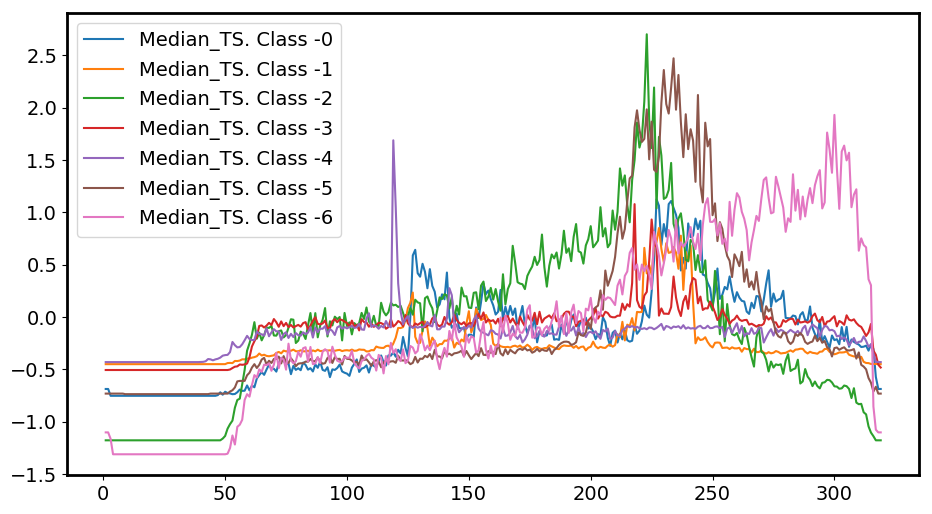

In [48]:
plot_sample_by_class(samples=train[0], labels=train_target)

Create TSC (Time Series Classification) model

In [49]:
basic_ts_clf_class = TimeSeriesClassifier(model_hyperparams={
        'problem': 'classification',
        'seed': 42,
        'timeout': 1,
        'max_depth': 4,
        'max_arity': 2,
        'cv_folds': 2,
        'logging_level': 50,
        'n_jobs': 2
    })

As a baseline, we will use a model based on statistical features of time series.
We will not use any additional transformations such as smoothing or sliding windows.

In [50]:
quantile_model_basic = StatsRunner(window_mode=False)
train_feats_baseline = quantile_model_basic.get_features(train[0], dataset_name)
test_feats_baseline = quantile_model_basic.get_features(test[0], dataset_name)

2022-12-21 13:07:32 - INFO - Number of TS to be processed: 70
2022-12-21 13:07:32 - INFO - Time spent on feature generation - 0.15 sec
2022-12-21 13:07:32 - INFO - Number of TS to be processed: 73
2022-12-21 13:07:32 - INFO - Time spent on feature generation - 0.16 sec


As a more complex model, we will use a model based on spectral features of time series.
An advanced version of this model allows you to reduce the dimension
of the feature space by grouping the PCT (principal component trajectory) among themselves.

In [51]:
spectral_model_basic = SSARunner(window_mode=False,
                                     window_sizes={dataset_name: [30]},
                                     spectral_hyperparams={'combine_eigenvectors': False,
                                                           'correlation_level': 0.8})
train_feats_spectral_basic = spectral_model_basic.get_features(train[0], dataset_name)
test_feats_spectral_basic = spectral_model_basic.get_features(test[0], dataset_name)
train_eigenvectors_spectral_basic = spectral_model_basic.eigenvectors_list_train

2022-12-21 13:07:32 - INFO - Generate features for window length - 30
2022-12-21 13:07:32 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 35/35 [00:03<00:00, 10.90 ts/s]
2022-12-21 13:07:35 - INFO - Number of time series processed: 35
2022-12-21 13:07:35 - INFO - Every eigenvector with impact less then 1 % percent was eliminated. 47 % of explained dispersion obtained by first - 4 components.
2022-12-21 13:07:35 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 70/70 [00:02<00:00, 32.88 ts/s]
2022-12-21 13:07:37 - INFO - Number of time series processed: 70
2022-12-21 13:07:39 - INFO - Window length = 30 was chosen
2022-12-21 13:07:39 - INFO - Time spent on feature generation - 6.85 sec
2022-12-21 13:07:39 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 73/73 [00:02<00:00, 26.13 ts/s]
2022-12-21 13:07:42 - INFO - Number of time series processed: 73
2022-12-21 13:07:43 - INFO - Time spen

Let's plot first 3 samples decomposed into PCT

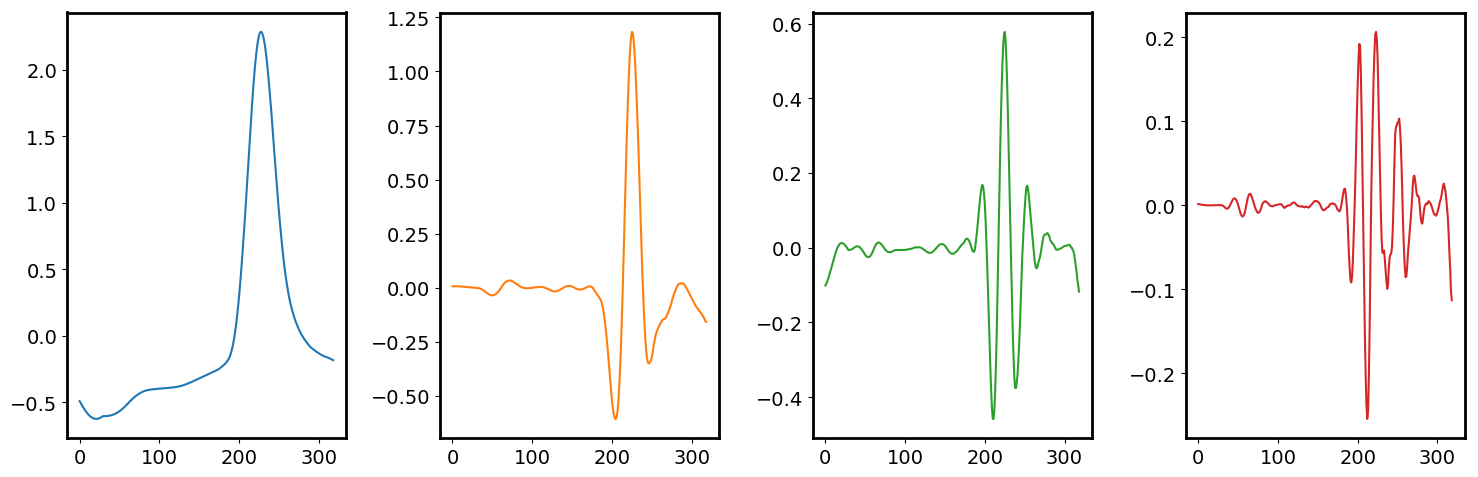

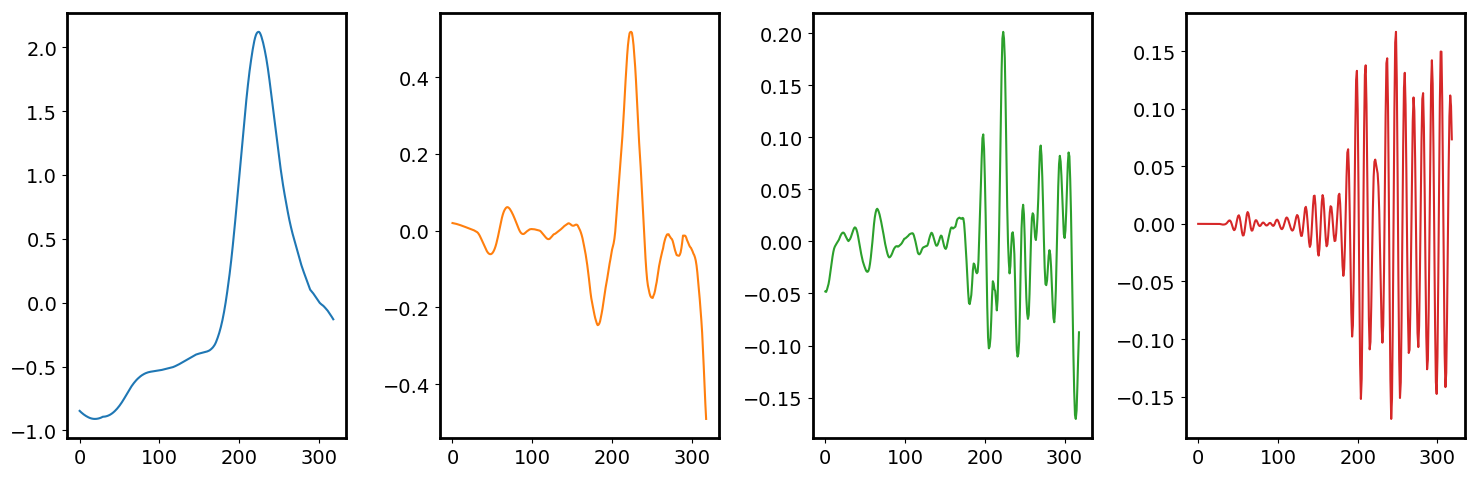

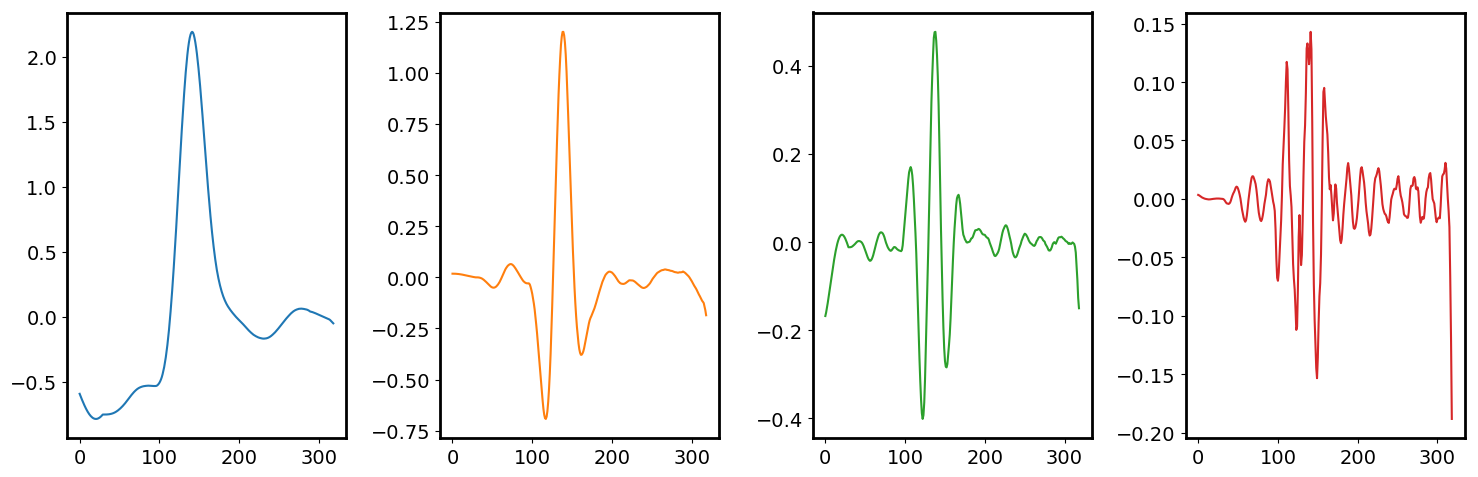

In [52]:
spectral_model_basic.visualise(train_eigenvectors_spectral_basic[:3])

Let's plot median of first PCT

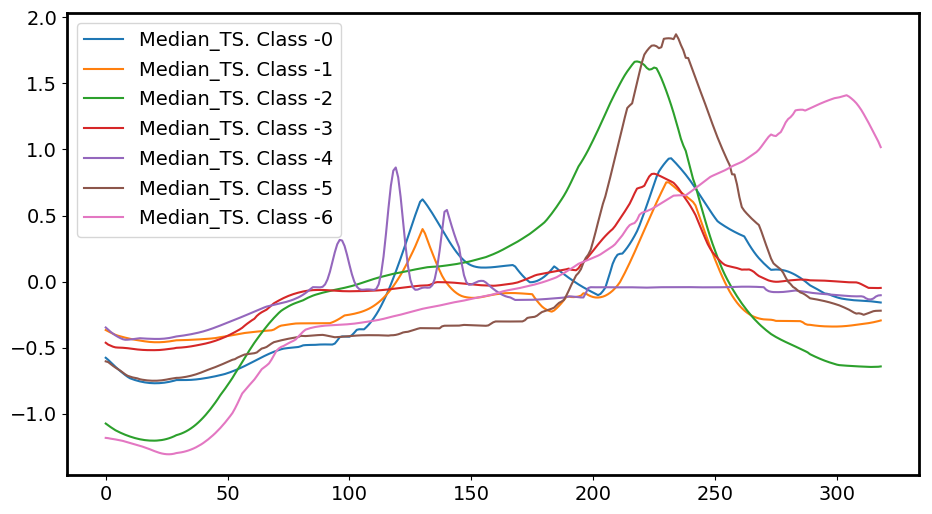

In [53]:
plot_sample_by_class(samples=train_eigenvectors_spectral_basic,
                     labels=train_target,
                     mode='F0')

Let's plot median of second PCT

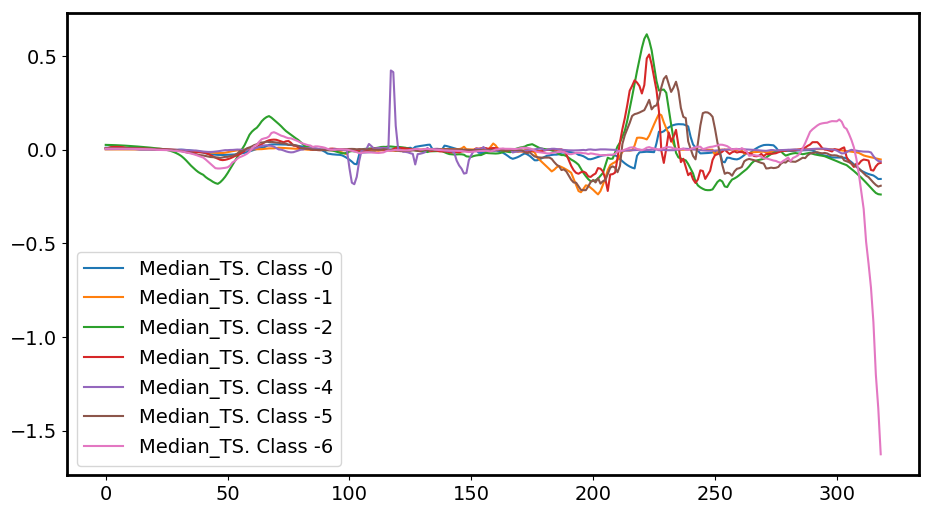

In [54]:
plot_sample_by_class(samples=train_eigenvectors_spectral_basic,
                     labels=train_target,
                     mode='F1')

In [55]:
spectral_model_advanced = SSARunner(window_mode=False,
                                    window_sizes={dataset_name: [30]},
                                    spectral_hyperparams={'combine_eigenvectors': True,
                                                          'correlation_level': 0.8})

train_feats_advanced = spectral_model_advanced.get_features(train[0], dataset_name)
test_feats_advanced = spectral_model_advanced.get_features(test[0], dataset_name)
train_eigenvectors_advanced = spectral_model_advanced.eigenvectors_list_train

2022-12-21 13:07:45 - INFO - Generate features for window length - 30
2022-12-21 13:07:45 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 35/35 [00:02<00:00, 16.17 ts/s]
2022-12-21 13:07:47 - INFO - Number of time series processed: 35
2022-12-21 13:07:47 - INFO - Every eigenvector with impact less then 1 % percent was eliminated. 46 % of explained dispersion obtained by first - 4 components.
2022-12-21 13:07:47 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 70/70 [00:02<00:00, 27.91 ts/s]
2022-12-21 13:07:50 - INFO - Number of time series processed: 70
2022-12-21 13:07:51 - INFO - Window length = 30 was chosen
2022-12-21 13:07:51 - INFO - Time spent on feature generation - 5.93 sec
2022-12-21 13:07:51 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 73/73 [00:02<00:00, 24.90 ts/s]
2022-12-21 13:07:54 - INFO - Number of time series processed: 73
2022-12-21 13:07:55 - INFO - Time spen

Let's plot first 3 samples decomposed into PCT (principal component trajectory)

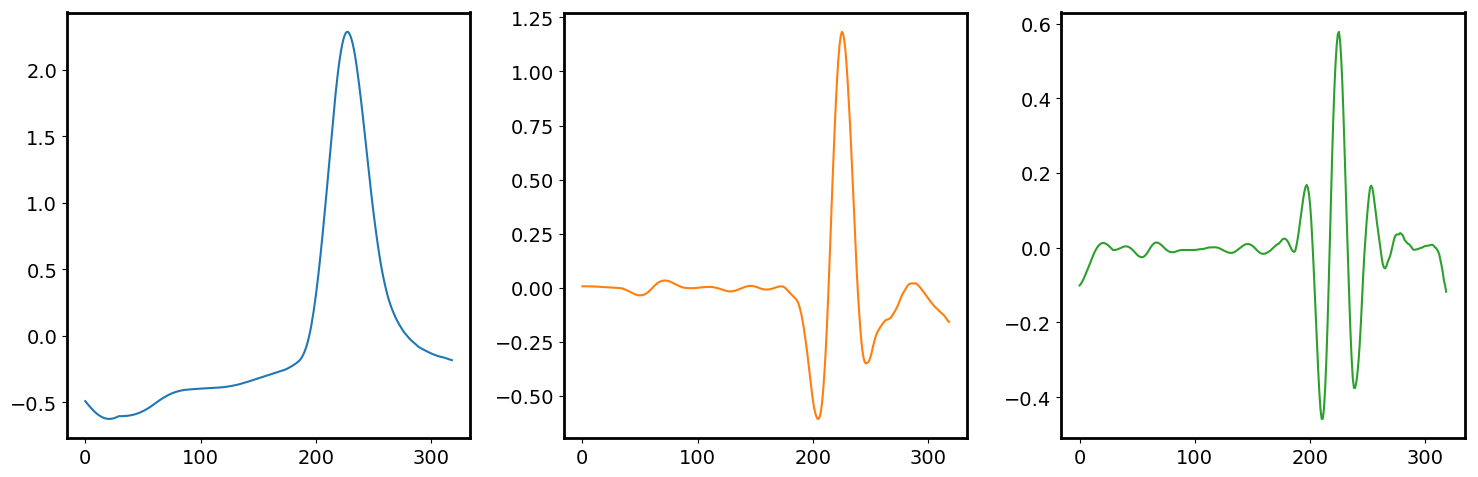

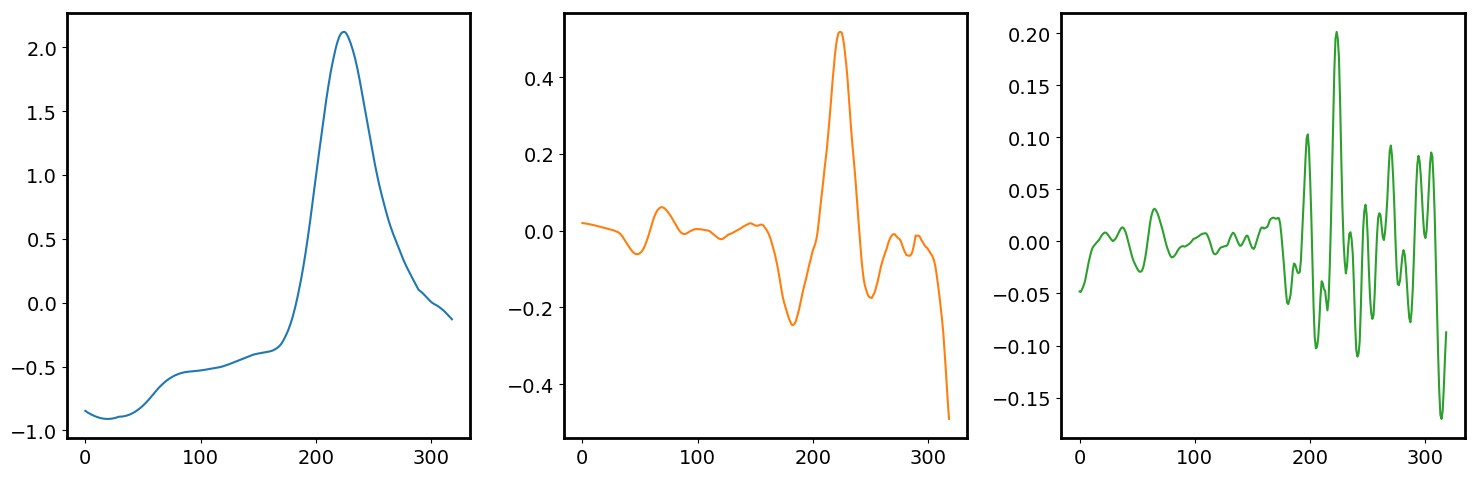

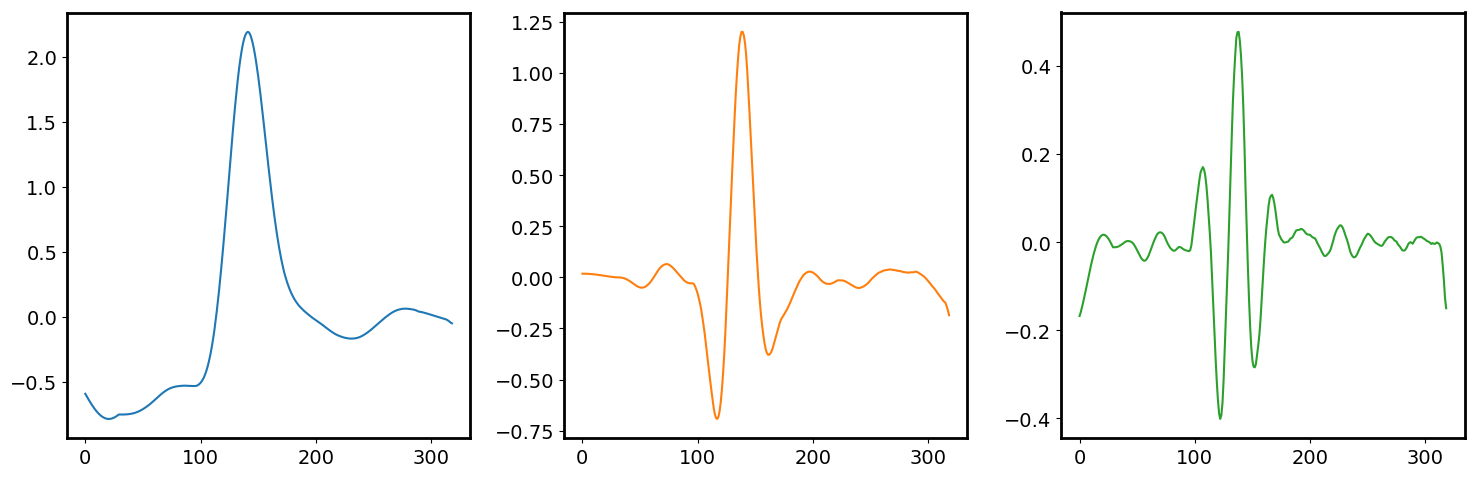

In [56]:
spectral_model_basic.visualise(train_eigenvectors_advanced[:3])

Let's plot median of first PCT

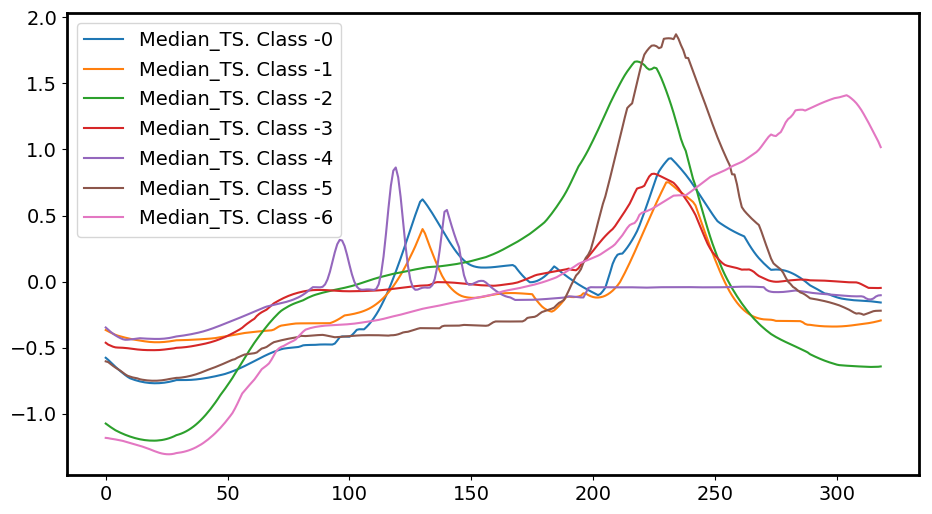

In [57]:
plot_sample_by_class(samples=train_eigenvectors_advanced,
                     labels=train_target,
                     mode=0)

Let's plot median of second PCT

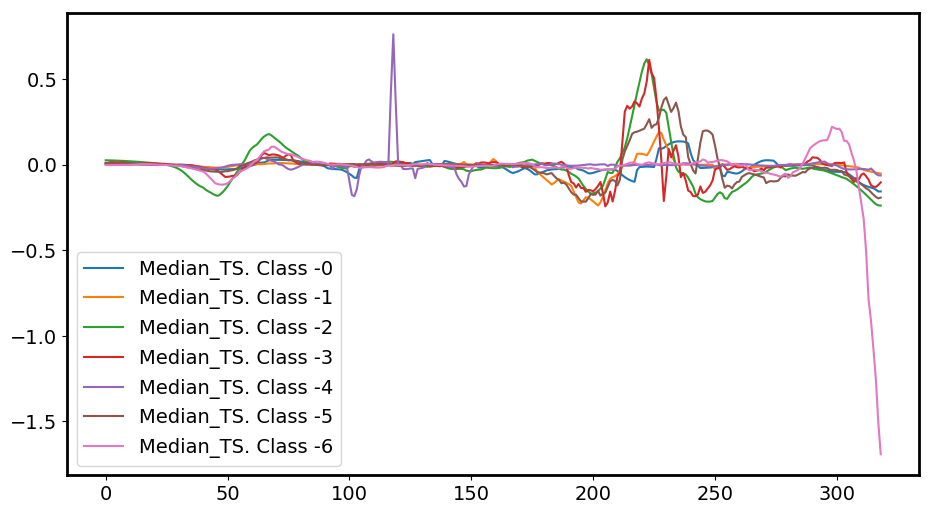

In [58]:
plot_sample_by_class(samples=train_eigenvectors_advanced,
                     labels=train_target,
                     mode=1)

In [59]:
metric_name = 'f1'
models_name = ['Statistical', 'BaseSpectral','AdvancedSpectral']
SOTA_results = [0.788201919, 0.744594487, 0.818165359, 0.794619584, 0.806207058,
                0.7286329, 0.781281546, 0.70060504, 0.680166882,
                0.671386013, 0.71358025, 0.694936093, 0.681765546, 0.62167202]
SOTA_model_names = ['TS-CHIEF',
                    'HIVE-COTE v1.0',
                    'InceptionTime',
                    'ROCKET',
                    'ResNet',
                    'STC'
                    'ProximityForest',
                    'WEASEL',
                    'S-BOSS',
                    'BOSS',
                    'cBOSS',
                    'TSFRISE',
                    'Catch22',
]
SOTA_dict = {k:v for k,v in zip(SOTA_model_names,SOTA_results)}

In [60]:
IndustrialModelBaseline = basic_ts_clf_class.fit(train_features=train_feats_baseline, train_target=train_target)[0]
baseline_results = get_results(basic_ts_clf_class, test_feats_baseline, test_target)
predict_baseline = basic_ts_clf_class.predict(test_feats_baseline)['label']

2022-12-21 13:07:57 - INFO - START TRAINING


2022-12-21 13:07:58,474 - ApiComposer - Initial pipeline was fitted in 0.2 sec.
2022-12-21 13:07:58,481 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-21 13:07:58,497 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

Metric evaluation error: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes
Metric evaluation error: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes
2022-12-21 13:08:00,399 - PipelineObjectiveEvaluate - Continuing after pipeline fit error <array must not contain infs or NaNs> for graph: (/n_fast_ica_{};)/n_rf_{'n_jobs': 1}
2022-12-21 13:08:06,887 - FedotKnnClassImplementation - n_neighbors of K-nn model was changed from 37 to 18
2022-12-21 13:08:10,519 - PipelineObjectiveEvaluate - Continuing after pipeline fit error <array must not contain infs or NaNs> for graph: (/n_fast_ica_{};)/n_rf_{'n_jobs': 1, 'n_estimators': 100, 'criterion': 'entropy', 'max_features': 0.5045212355054942, 'min_samples_split': 9, 'min_samples_leaf': 12, 'bootstrap': False}
2022-12-21 13:08:23,503 - PipelineObjectiveEvaluate - Continuing after pipeline fit error <array must not contain infs or NaNs>

Generations:   0%|          | 1/10000 [00:36<?, ?gen/s]

2022-12-21 13:08:35,161 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


  0%|          | 39/100000 [00:23<16:43:10,  1.66trial/s, best loss: -0.8977010000000001]
2022-12-21 13:08:59,856 - ApiComposer - Hyperparameters tuning finished
2022-12-21 13:09:00,051 - ApiComposer - Model generation finished


In [61]:
baseline_results

{'roc_auc': 0.844,
 'f1': 0.427,
 'precision': 0.503,
 'accuracy': 0.479,
 'logloss': 1.796}

In [62]:
compare_results(sota_dict=SOTA_dict,
                current_results=baseline_results[metric_name])

FEDOT_TSC worse than TS-CHIEF by 36 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 32 %
FEDOT_TSC worse than InceptionTime by 39 %
FEDOT_TSC worse than ROCKET by 37 %
FEDOT_TSC worse than ResNet by 38 %
FEDOT_TSC worse than STCProximityForest by 30 %
FEDOT_TSC worse than WEASEL by 35 %
FEDOT_TSC worse than S-BOSS by 27 %
FEDOT_TSC worse than BOSS by 25 %
FEDOT_TSC worse than cBOSS by 24 %
FEDOT_TSC worse than TSFRISE by 29 %
FEDOT_TSC worse than Catch22 by 27 %
FEDOT_TSC better than - 0 % SOTA models


In [63]:
IndustrialModelSpectral = basic_ts_clf_class.fit(train_features=train_feats_spectral_basic,
                                                 train_target=train_target)[0]

basic_result = get_results(basic_ts_clf_class, test_feats_spectral_basic, test_target)
predict_basic = basic_ts_clf_class.predict(test_feats_spectral_basic)['label']

2022-12-21 13:09:00 - INFO - START TRAINING


2022-12-21 13:09:00,473 - ApiComposer - Initial pipeline was fitted in 0.2 sec.
2022-12-21 13:09:00,479 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-21 13:09:00,494 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-21 13:09:36,833 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:36<?, ?gen/s]

2022-12-21 13:09:36,839 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


  0%|          | 63/100000 [00:23<10:14:03,  2.71trial/s, best loss: -0.923292]
2022-12-21 13:10:00,797 - ApiComposer - Hyperparameters tuning finished
2022-12-21 13:10:01,011 - ApiComposer - Model generation finished


In [64]:
basic_result

{'roc_auc': 0.903,
 'f1': 0.537,
 'precision': 0.596,
 'accuracy': 0.548,
 'logloss': 1.193}

In [65]:
print(f'Quality metric gain - {round((basic_result[metric_name]-baseline_results[metric_name])*100)} %')

Quality metric gain - 11 %


In [66]:
compare_results(sota_dict=SOTA_dict,
                current_results=basic_result[metric_name])

FEDOT_TSC worse than TS-CHIEF by 25 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 21 %
FEDOT_TSC worse than InceptionTime by 28 %
FEDOT_TSC worse than ROCKET by 26 %
FEDOT_TSC worse than ResNet by 27 %
FEDOT_TSC worse than STCProximityForest by 19 %
FEDOT_TSC worse than WEASEL by 24 %
FEDOT_TSC worse than S-BOSS by 16 %
FEDOT_TSC worse than BOSS by 14 %
FEDOT_TSC worse than cBOSS by 13 %
FEDOT_TSC worse than TSFRISE by 18 %
FEDOT_TSC worse than Catch22 by 16 %
FEDOT_TSC better than - 0 % SOTA models


In [67]:
IndustrialModelSpectralAdvanced = basic_ts_clf_class.fit(train_features=train_feats_advanced,
                                                         train_target=train_target)[0]

advanced_result = get_results(basic_ts_clf_class, test_feats_advanced, test_target)
predict_advanced = basic_ts_clf_class.predict(test_feats_advanced)['label']

2022-12-21 13:10:01 - INFO - START TRAINING


2022-12-21 13:10:01,473 - ApiComposer - Initial pipeline was fitted in 0.2 sec.
2022-12-21 13:10:01,479 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-21 13:10:01,494 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-21 13:10:33,637 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:32<?, ?gen/s]

2022-12-21 13:10:33,642 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 376/100000 [00:27<1:59:16, 13.92trial/s, best loss: -0.944607]         
2022-12-21 13:11:00,790 - ApiComposer - Hyperparameters tuning finished
2022-12-21 13:11:00,996 - ApiComposer - Model generation finished


In [68]:
advanced_result

{'roc_auc': 0.957,
 'f1': 0.663,
 'precision': 0.719,
 'accuracy': 0.658,
 'logloss': 0.879}

In [69]:
print(f'Quality metric gain - {round((advanced_result[metric_name]-basic_result[metric_name])*100)} %')

Quality metric gain - 13 %


In [70]:
compare_results(sota_dict=SOTA_dict,
                current_results=advanced_result[metric_name])

FEDOT_TSC worse than TS-CHIEF by 13 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 8 %
FEDOT_TSC worse than InceptionTime by 16 %
FEDOT_TSC worse than ROCKET by 13 %
FEDOT_TSC worse than ResNet by 14 %
FEDOT_TSC worse than STCProximityForest by 7 %
FEDOT_TSC worse than WEASEL by 12 %
FEDOT_TSC worse than S-BOSS by 4 %
FEDOT_TSC worse than BOSS by 2 %
FEDOT_TSC worse than cBOSS by 1 %
FEDOT_TSC worse than TSFRISE by 5 %
FEDOT_TSC worse than Catch22 by 3 %
FEDOT_TSC better than - 0 % SOTA models


In [71]:
for predict,model_name in zip([predict_baseline,predict_basic,predict_advanced],models_name):
    print(f'Confusion Matrix for model - {model_name}')
    print(classification_report(test_target, predict))

Confusion Matrix for model - Statistical
              precision    recall  f1-score   support

           0       0.22      0.20      0.21        10
           1       1.00      0.11      0.20         9
           2       0.36      0.67      0.47         6
           3       0.33      1.00      0.50         7
           4       0.00      0.00      0.00        10
           5       0.60      0.79      0.68        19
           6       1.00      0.50      0.67        12

    accuracy                           0.48        73
   macro avg       0.50      0.47      0.39        73
weighted avg       0.54      0.48      0.43        73

Confusion Matrix for model - BaseSpectral
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.42      0.56      0.48         9
           2       0.80      0.67      0.73         6
           3       0.41      1.00      0.58         7
           4       0.86      0.60      0.71      